In [9]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cell2location
import scvi
import os
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
import seaborn as sns
import time
import gc
gc.collect()

505

In [10]:
# load data
cellcount = "/data/myi/mt-spatial-transcriptomics/data/processed/sc_counts_SHK166_RA_Knee.mtx"
celltype = "/data/myi/mt-spatial-transcriptomics/data/processed/ctypes7_SHK166_RA_Knee.csv"
# sp_data = "/home/myi/data/spatial-trancriptomics/st_counts_SHK166_RA_Knee.mtx"
sp_data = "/data/myi/mt-spatial-transcriptomics/data/SHK166_RA_Knee/sp_counts_SHK166_RA_Knee.mtx"

start_time = time.time()
adata_ref = sc.read_mtx(cellcount).transpose()
df_celltype = pd.read_csv(celltype, header=0, index_col=0)
df_celltype.index = adata_ref.obs.index
adata_ref.obs['ctypes'] = df_celltype

shuffled_obs_indices = np.random.permutation(adata_ref.n_obs)
adata_ref = adata_ref[shuffled_obs_indices, :]

N_cells_per_location = 7


In [11]:
adata_ref.obs.keys()


Index(['ctypes'], dtype='object')

/home/myi/data/conda/envs/c2l/lib/python3.9/site-packages/cell2location/utils/filtering.py:26: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = np.array((adata.X > 0).sum(0)).flatten()
/home/myi/data/conda/envs/c2l/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


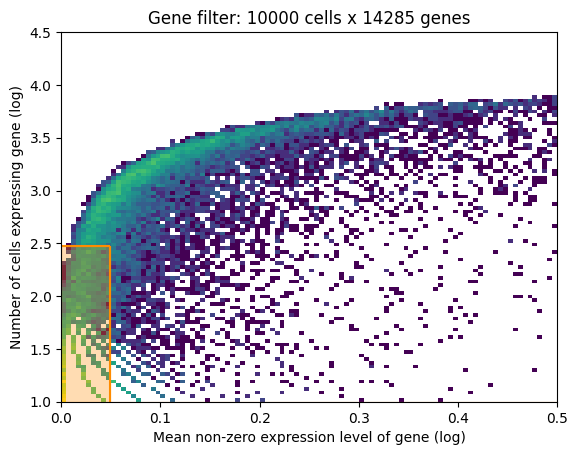

In [12]:
# QC
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
# 5, 0.03, 1.12

# In our case, a few genes are cut
adata_ref = adata_ref[:, selected].copy()

In [13]:
ref_counts = adata_ref.X
print(ref_counts.shape)

(10000, 14285)


In [14]:

# Convert sparse matrix to dense DataFrame
ref_counts = pd.DataFrame.sparse.from_spmatrix(adata_ref.X, columns=adata_ref.var_names, index=adata_ref.obs_names) # cell by genes

# Add ctypes information
ref_counts['ctypes'] = df_celltype
print(ref_counts.shape)
print(df_celltype.shape)

inf_aver = ref_counts.groupby('ctypes').agg("mean").reset_index() # gene by ctypes
print(inf_aver.shape)
ctypes_unique = inf_aver['ctypes'].dropna()
print(ctypes_unique)

inf_aver = inf_aver.drop(columns=['ctypes']).transpose()
inf_aver.columns = ctypes_unique
# Note that the column names are cell types, the row names are gene names, in the original code
# the authors use ENSEMBL as names instead of raw gene names


(10000, 14286)
(10000, 1)
(7, 14286)
0                B Cells
1      Endothelial Cells
2                Myeloid
3           Plasma Cells
4    Smooth Muscle Cells
5                 SynFib
6                 TCells
Name: ctypes, dtype: object


/home/myi/data/conda/envs/c2l/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/myi/data/conda/envs/c2l/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 2431  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 5454  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

/home/myi/data/conda/envs/c2l/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/myi/data/conda/envs/c2l/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
/home/myi/data/conda/envs/c2l/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset

Epoch 20000/20000: 100%|██████████| 20000/20000 [24:04<00:00, 13.61it/s, v_num=1, elbo_train=7.44e+6]

`Trainer.fit` stopped: `max_epochs=20000` reached.


Epoch 20000/20000: 100%|██████████| 20000/20000 [24:04<00:00, 13.85it/s, v_num=1, elbo_train=7.44e+6]


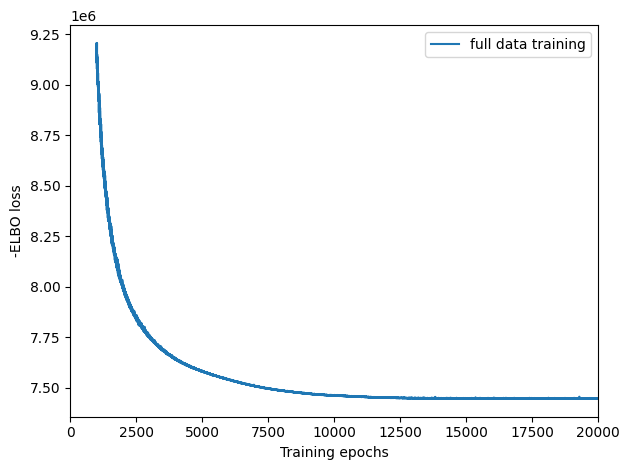

In [15]:
# ST
adata_vis = sc.read_mtx(sp_data).transpose() # cells by genes

adata_vis.obs['sample'] = 'SHK' 

# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
# cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")
cell2location.models.Cell2location.setup_anndata(adata=adata_vis)

# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=N_cells_per_location,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

mod.train(max_epochs=20000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

/home/myi/data/conda/envs/c2l/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:17<00:00, 56.52it/s]


'cell2loc/sp.h5ad'

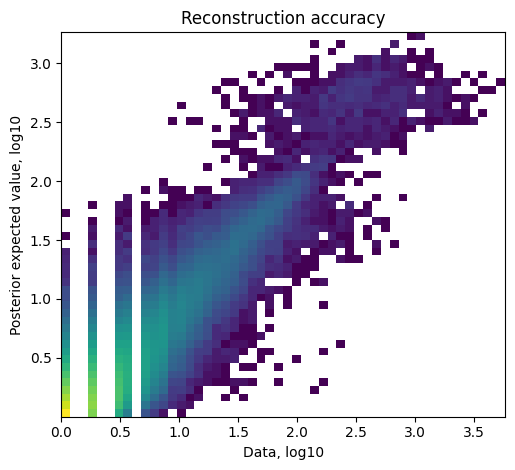

In [16]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

mod.plot_QC()
# plt.savefig(f"./posterior.png",
#                 bbox_inches='tight')
# plt.close()

# Save model
run_name = "cell2loc"
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file


In [17]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']
result1 = adata_vis.obsm['q05_cell_abundance_w_sf']
result2 = adata_vis.obsm['q95_cell_abundance_w_sf']
result3 = adata_vis.obsm['means_cell_abundance_w_sf']


In [18]:
colnames = result3.columns.to_list()
colnames_short = [x[x.rfind("_") + 1:] for x in colnames]
print(result3.columns)
result3.columns = colnames_short

Index(['meanscell_abundance_w_sf_B Cells',
       'meanscell_abundance_w_sf_Endothelial Cells',
       'meanscell_abundance_w_sf_Myeloid',
       'meanscell_abundance_w_sf_Plasma Cells',
       'meanscell_abundance_w_sf_Smooth Muscle Cells',
       'meanscell_abundance_w_sf_SynFib', 'meanscell_abundance_w_sf_TCells'],
      dtype='object')


In [1]:
parent_path = "/home/myi/data/mt-spatial-transcriptomics/results/deconvolution/cell2loc"

sum_result_3 = result3.sum(axis=1)
result3_percent = result3.div(result3.assign(total=sum_result_3)['total'], axis='index')
print(result3_percent.shape)
result_name = os.path.join(parent_path, "deconProp.csv")

result3_percent.index = adata_vis.X.index
print(result3_percent.index[1])
result3_percent.to_csv(result_name, index=True)


NameError: name 'result3' is not defined